In [2]:
print('Takumi House & Kailen Santos')

Takumi House & Kailen Santos


Our original pitch was the following: <br>
People rarely report cases of food poisoning to the appropriate government bodies. However, they are more likely to post on restaurant review apps like Yelp, sharing their negative experiences. <br>
Our plan is to use the Yelp API to search for key terms like ‘sick’, ‘food poisoning’, ‘nausea’, ‘throw up’ to see if there are any restaurants in the Boston area that have noticeably high-frequency reports of cases of food poisoning. Then, we will cross reference them with the Boston Health Inspection dataset from the Boston Inspectional Services Department see if there are any restaurants that are slipping through the cracks of the health inspectors, and whether or not we can predict at which restaurants patrons are most at risk. We can then see if there are certain locations, or certain kinds of restaurants, that seem to result in higher numbers of food safety infractions. <br>
Our first challenge came with the Yelp API. Due to registration issues and limitations of the API, we realized quickly that the API was not capable of carrying out our proposed project, even though we had data regarding health inspection data from the City of Boston Open Data Portal. We looked into the use of other APIs, like the FourSquare API, which was more user-friendly and could provide us with full text reviews of restaurants. Although the businesses on the FourSquare API had fewer users, and therefore fewer reviews, we were optimistic that we could still make use of the data. We started caching the data information returned by the FourSquare API, but soon realized that, although there was a fair amount of traffic on any given business, the total number of businesses registered on FourSquare were far fewer in number. The FourSquare API also lacks a pagination parameter, which made a complete scrape of Boston's restaurants difficult. <br>
Upon Professor Terzi's recommendation, we turned to the Yelp Academic Dataset. We were hesitant at first to use the Academic Dataset, namely due to the fact that the information is static, and as mentioned on the Yelp Dataset Challenge page, the dataset is made up of \"Only the reviews that Yelp recommended at the time of data collection.\" We were concerned, due to past reports of unfair review filtering on Yelp's part, that this may have meant that there was a bias in the data towards positive reviews. However, upon further inspection, it appears that recommended reviews are reviews that best indicate the average opinion of the business, and would therefore be a good indicator of public opinion. This means that we won't get all of the reviews for every business, but we are hopeful that there are telling reviews within this subset. The dataset was first released in 2013, but was updated most recently in January of 2017. Unlike the API, the Academic Dataset offered full text reviews, which is crucial to the success of our project. We decided to use Las Vegas as our test city because Las Vegas has their own Open Data Portal, where we found a Restaurant Inspections Dataset within their Public Safety Division. Similar to the one found for Boston, it contains restaurants, violations, ensuing consequences, etc. This is perfect for our comparisons. Additionally, Las Vegas has more than twice the number of restaurants than the second most frequent city in the dataset, and more than three times the number of reviews than the second most frequent city in the dataset.

In [3]:
from matplotlib import pyplot as plt
import matplotlib as mp
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import sklearn.manifold
from scipy import cluster
import seaborn as sns
import sklearn.datasets as sk_data
import sklearn.metrics as metrics
import requests
import json
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
import re
import json
import pickle
%matplotlib inline

We begin by cleaning the academic dataset of irrelevant business. We only want too look at restaurants in Las Vegas, so we iterate through all of the json objects and filter out the unneeeded businesses, and add them to a list names.

In [7]:
restaurants = {}
names=[]
with open('yelp_academic_dataset_business.json') as data:
    for i in data:
        d = json.loads(i)
        if (d['city']=='Las Vegas'):
            if ('Restaurants' in d['categories']):
                restaurants[d['business_id']] = {'latitude':d['latitude'], 'longitude':d['longitude'], 'address':d['full_address']}
                names.append(d['name'])
# restaurants

In [9]:
bId = []
long = []
lat = []
address = []

for x, y in restaurants.items():
    bId.append(x)
    long.append((y.get('longitude')))
    lat.append((y.get('latitude')))
    address.append(((y.get('address')).rsplit('\n', 5)[0]).lower())
long = np.array(long)
lat = np.array(lat)

print(long)
print(lat)

[-115.1016523  -115.1744147  -115.1709763  ..., -115.17327619 -115.295238
 -115.1074743 ]
[ 36.0997319   36.1277253   36.1142773  ...,  36.11188677  36.1444429
  35.9992047 ]


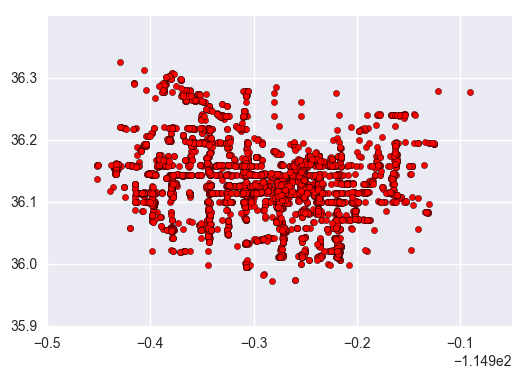

In [10]:
plt.scatter(long, lat, c='red', s=20)

In [11]:
# file = 'Restaurant_Inspections.json'
# data = []
# with open(file) as f:
#     for line in f:
#         data.append(json.loads(line))

We read in the Restaurant Inspections dataset into a pandas dataframe.

In [12]:
df = pd.read_csv('Restaurant_Inspections.csv',header=0)
# df = df[df.City == 'Las Vegas']
# df = (df[df['Inspection Result'] == 'Closed with Fees']).append(df[df['Inspection Result'] == 'Closed without Fees'])

df.shape

#with open ('Resaurant_Inspections.csv') as file:
#   for line in file:
#      if (line[6]=='Las Vegas' && line[]

C:\Users\Kailen\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(123919, 23)

We begin cleaning the dataset by checking the cities in which these health inspections took place. Although this dataset is from the Las Vegas Open Data Portal, it contains data from restaurants all around Nevada, as far as 70 miles from the city.
I decide to do this in a step by step process, making sure to check how many lines are removed by every parameter.

In [13]:
df = df[df.City == 'Las Vegas']
df.shape

(94700, 23)

Next, we clean the dataset of health code inspections that do not pertain to restaurants. <br> We define restaurants to be: <br> Places of business open to the public who serve food in exchange for monetary payment. <br> Therefore, we remove the categories that do no adhere to these standards.

In [14]:
categories = df['Category Name'].unique().tolist()
print(categories)

['Pantry', 'Special Kitchen', 'Garde Manger', 'Kitchen Bakery', 'Bar / Tavern', 'Buffet', 'Snack Bar', 'Restaurant', 'Banquet Support', 'Portable Unit', 'Banquet Kitchen', 'Portable Bar', 'Meat/Poultry/Seafood', 'Vegetable Prep', 'Caterer', 'Barbeque', 'Confection', 'Concessions', 'Produce Market', 'Institutional Food Service', 'Elementary School Kitchen', 'Self-Service Food Truck', 'Bakery Sales', 'Food Trucks / Mobile Vendor', 'Grocery Store Sampling', 'Beer Bar', 'Childcare Kitchens', "Farmer's Market", 'Main Kitchen', 'Frozen Meat Sales']


In [15]:
categories.remove('Elementary School Kitchen')
categories.remove('Grocery Store Sampling')
categories.remove('Farmer\'s Market')
categories.remove('Caterer')
categories.remove('Concessions')
categories.remove('Institutional Food Service')
categories.remove('Banquet Support')

In [16]:
df = df[df['Category Name'].isin(categories)]
df.shape

(91735, 23)

In [17]:
coord_strings = df['Location 1'].tolist()

We convert our points from strings to the appropriate float tuple format, and plot our points to see what our spread of inspec looks like.

In [18]:
import ast
xcoords = []
ycoords = []
for coord in coord_strings:
    xcoords.append(ast.literal_eval(coord)[0])
    ycoords.append(ast.literal_eval(coord)[1])

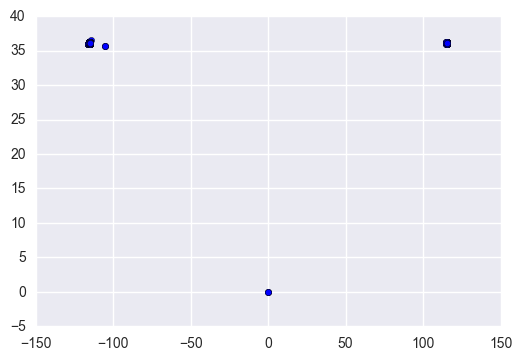

In [19]:
plt.scatter(ycoords, xcoords, c = 'b')

It is evident that there are some outlier coordinates. We aren't certain whether these are due to input errors, or because our cleaning was not sufficient.

Upon further inspection, we realize that some of the y coordinates have erroneously been negated, from ~-115 to ~115. We iterate through the dataset and fix the offending coordinates.

In [20]:
count = 0
for idx, ycoord in enumerate(ycoords):
    if ycoord > 0:
        ycoords[idx] = ycoord * -1
        count += 1
print('{} coordinates fixed.'.format(count))

574 coordinates fixed.


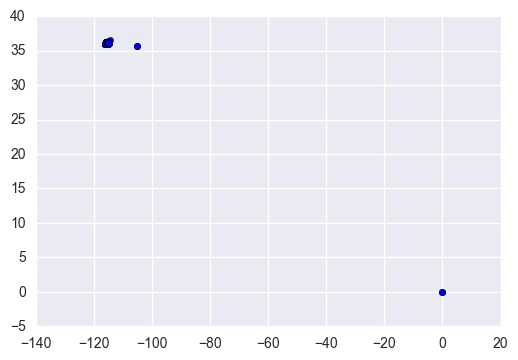

In [18]:
plt.scatter(ycoords, xcoords, c = 'b')

That's better, but it looks like there are a few points at (0,0), likely because coordinate information wasn't provided.

In [15]:
# df = df[df['Location 1'] != '(0, 0)']
df['Coordinates'] = list(zip(xcoords, ycoords))
df.head()

,Serial Number,Permit Number,Restaurant Name,Location Name,Category Name,Address,City,State,Zip,Current Demerits,...,Employee ID,Inspection Type,Inspection Demerits,Inspection Grade,Permit Status,Inspection Result,Violations,Record Updated,Location 1,Coordinates
11,DA0001715,PR0000426,CAESARS AUGUSTUS BUTLER PANTRY,CAESARS PALACE HOTEL & CASINO,Pantry,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,EE7000417,Routine Inspection,0,A,NaN,Compliant,NaN,02/21/2013 10:26:12 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)"
12,DA0001716,PR0000426,CAESARS AUGUSTUS BUTLER PANTRY,CAESARS PALACE HOTEL & CASINO,Pantry,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,EE7000567,Routine Inspection,2,A,NaN,Compliant,NaN,02/21/2013 10:26:12 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)"
13,DA0001728,PR0000427,CAESARS DIAMOND LOUNGE KITCHEN,CAESARS PALACE HOTEL & CASINO,Special Kitchen,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,8,...,EE7000417,Routine Inspection,4,A,NaN,Compliant,14,02/21/2013 10:26:12 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)"
14,DA0001773,PR0000434,CAESARS BAKERY WAREWASH,CAESARS PALACE HOTEL & CASINO,Special Kitchen,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,EE7000417,Routine Inspection,7,A,NaN,Compliant,14232831,01/22/2014 02:03:44 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)"
15,DA0001776,PR0000434,CAESARS BAKERY WAREWASH,CAESARS PALACE HOTEL & CASINO,Special Kitchen,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,EE7000392,Routine Inspection,2,A,NaN,Compliant,NaN,01/22/2014 02:03:44 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)"


In [16]:
df = df[df['Coordinates'] != (0,0)]
# df = df[df['Coordinates'][1] < -112]
df.shape

(91732, 24)

Creating Series in the df for ease of use when checking coordinate limits.

In [17]:
coordinates_list = df['Coordinates'].tolist()
xcoords = []
ycoords = []
for coordinates in coordinates_list:
    xcoords.append(coordinates[0])
    ycoords.append(coordinates[1])
df['X'] = xcoords
df['Y'] = ycoords
df.head()

,Serial Number,Permit Number,Restaurant Name,Location Name,Category Name,Address,City,State,Zip,Current Demerits,...,Inspection Demerits,Inspection Grade,Permit Status,Inspection Result,Violations,Record Updated,Location 1,Coordinates,X,Y
11,DA0001715,PR0000426,CAESARS AUGUSTUS BUTLER PANTRY,CAESARS PALACE HOTEL & CASINO,Pantry,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,0,A,NaN,Compliant,NaN,02/21/2013 10:26:12 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)",36.116156,-115.175058
12,DA0001716,PR0000426,CAESARS AUGUSTUS BUTLER PANTRY,CAESARS PALACE HOTEL & CASINO,Pantry,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,2,A,NaN,Compliant,NaN,02/21/2013 10:26:12 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)",36.116156,-115.175058
13,DA0001728,PR0000427,CAESARS DIAMOND LOUNGE KITCHEN,CAESARS PALACE HOTEL & CASINO,Special Kitchen,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,8,...,4,A,NaN,Compliant,14,02/21/2013 10:26:12 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)",36.116156,-115.175058
14,DA0001773,PR0000434,CAESARS BAKERY WAREWASH,CAESARS PALACE HOTEL & CASINO,Special Kitchen,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,7,A,NaN,Compliant,14232831,01/22/2014 02:03:44 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)",36.116156,-115.175058
15,DA0001776,PR0000434,CAESARS BAKERY WAREWASH,CAESARS PALACE HOTEL & CASINO,Special Kitchen,3570 S Las Vegas Blvd,Las Vegas,Nevada,89109-8924,3,...,2,A,NaN,Compliant,NaN,01/22/2014 02:03:44 PM,"(36.1161559, -115.1750576)","(36.1161559, -115.1750576)",36.116156,-115.175058


Based on maps and resources online, and the spread of our reviews, we set upper and lower limits, which is an area of approximately 100 km, more enough to include all of Las Vegas.

In [18]:
df = df[df['Y'] < -114.5]
df = df[df['Y'] > -115.6]
df.shape

(91701, 26)

In [19]:
df_clean = df.reset_index(drop = True)
df_clean.shape

(91701, 26)

In [20]:
coordinates_list = df_clean['Coordinates'].tolist()
xcoords = []
ycoords = []
for coordinates in coordinates_list:
    xcoords.append(coordinates[0])
    ycoords.append(coordinates[1])

The new plot of health inspection reports.

In [ ]:
plt.scatter(ycoords, xcoords, c = 'b')

A plot of health inspection reports overlayed on th set of restaurants in the academic dataset. It looks like a fairly good spread.

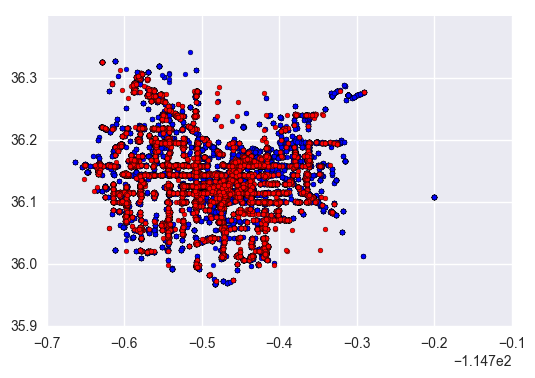

In [22]:
plt.scatter(ycoords, xcoords, c = 'b', s=12)
plt.scatter(long, lat, c='r', s=12)

After visualizing the spread resulting from the plot above, we aggregate the violation data by restaurant.

In [23]:
df_agg = df.groupby('Restaurant Name',as_index=False).agg(lambda x: x.tolist())

In [24]:
dfcategories = df_agg.columns
for x in dfcategories[1:]:
    for y in range(len(df_agg[x])):
        df_agg[x][y] = list(set(df_agg[x][y]))

In [25]:
for x in dfcategories[22:]:
    for y in range(len(df_agg[x])):
        df_agg[x][y] = df_agg[x][y][0]

In [26]:
df_agg.head()

,Restaurant Name,Serial Number,Permit Number,Location Name,Category Name,Address,City,State,Zip,Current Demerits,...,Inspection Demerits,Inspection Grade,Permit Status,Inspection Result,Violations,Record Updated,Location 1,Coordinates,X,Y
0,#1 HAWAIIAN BARBEQUE,"[DA1444962, DA1282153, DA1637505, DA1520589, D...",[PR0110047],[CHINA DRAGON/#1 HAWAIIAN BARBEQUE],[Restaurant],[5905 S EASTERN Ave 105],[Las Vegas],[Nevada],[89119],[9],...,"[0, 3, 6, 8, 9, 17, 19, 20, 27]","[B, nan, C, A]","[nan, B, A]","['A' Grade, Compliant, 'C' Downgrade, 'B' Down...","[nan, 211215292829302955, 20220821529082928293...","[01/30/2015 04:05:28 PM, 06/09/2015 09:52:01 A...","(36.0820114, -115.119644)","(36.0820114, -115.119644)",36.082,-115.12
1,$5 CAFE,"[DA1640753, DA1510775, DA1280693, DADY9VZ5M]",[PR0017837],[AZTEC INN - $5 CAFE],[Restaurant],[2200 S Las Vegas Blvd],[Las Vegas],[Nevada],[89104-2527],[10],...,"[8, 10, 6]",[A],"[nan, A]","['A' Grade, Compliant]","[20229292955, 202206291029282930, 2022172912, ...","[01/11/2016 09:09:42 AM, 09/17/2014 08:43:23 A...","(36.1459136, -115.1561175)","(36.1459136, -115.1561175)",36.1459,-115.156
2,100 DEGREES HOT POT - DELETED 10/15,"[DA1494935, DA1500853]",[PR0113718],[100 DEGREES HOT POT],[Restaurant],[5600 SPRING MOUNTAIN Rd B],[Las Vegas],[Nevada],[89146],[3],...,"[3, 20]","[B, A]",[nan],"[Compliant, 'B' Downgrade]","[2122911, 20821521829092912292929552956]","[04/29/2015 01:02:30 PM, 04/15/2015 09:57:26 AM]","(36.1265084, -115.2182851)","(36.1265084, -115.2182851)",36.1265,-115.218
3,101 MART SNACK BAR,"[DAV0HMPRO, DATYVW3XN]",[PR0118514],[101 MART],[Snack Bar],[1021 CONVENTION CENTER Dr],[Las Vegas],[Nevada],[89109],[6],...,"[3, 6]",[A],"[nan, A]",['A' Grade],"[2152955, 291229282955]","[07/26/2016 02:15:51 PM, 04/10/2017 03:52:34 PM]","(36.1322288, -115.1553506)","(36.1322288, -115.1553506)",36.1322,-115.155
4,168 Market - Bakery,"[DA1523505, DAHDRCSW0, DA0629041, DA1106115, D...",[PR0021447],[168 Market],[Bakery Sales],[3459 S Jones Blvd],[Las Vegas],[Nevada],[89146-6729],[3],...,"[0, 3, 5, 6, 7, 8, 9, 19]","[B, A]","[nan, nan, nan, nan]","['A' Grade, Compliant, 'B' Downgrade]","[nan, 217, 209217, 2112930, 2152955, 215290929...","[06/22/2016 04:04:37 PM, 02/21/2013 10:26:12 P...","(36.1265813, -115.2250088)","(36.1265813, -115.2250088)",36.1266,-115.225


In [27]:
for x in dfcategories[1:22]:
    for y in range(len(df_agg[x])):
        if ((isinstance(df_agg[x][y][0], float) or isinstance(df_agg[x][y][0], str) or isinstance(df_agg[x][y][0], np.int64)) and len(df_agg[x][y])>1 ):
            df_agg[x][y] = ''.join((str(e) +', ') for e in df_agg[x][y])
        else:
            df_agg[x][y] = ''.join(str(df_agg[x][y][0]))

In [28]:
df_agg.head()

,Restaurant Name,Serial Number,Permit Number,Location Name,Category Name,Address,City,State,Zip,Current Demerits,...,Inspection Demerits,Inspection Grade,Permit Status,Inspection Result,Violations,Record Updated,Location 1,Coordinates,X,Y
0,#1 HAWAIIAN BARBEQUE,"DA1444962, DA1282153, DA1637505, DA1520589, DA...",PR0110047,CHINA DRAGON/#1 HAWAIIAN BARBEQUE,Restaurant,5905 S EASTERN Ave 105,Las Vegas,Nevada,89119,9,...,"0, 3, 6, 8, 9, 17, 19, 20, 27,","B, nan, C, A,","nan, B, A,","'A' Grade, Compliant, 'C' Downgrade, 'B' Downg...","nan, 211215292829302955, 202208215290829282930...","01/30/2015 04:05:28 PM, 06/09/2015 09:52:01 AM...","(36.0820114, -115.119644)","(36.0820114, -115.119644)",36.082,-115.12
1,$5 CAFE,"DA1640753, DA1510775, DA1280693, DADY9VZ5M,",PR0017837,AZTEC INN - $5 CAFE,Restaurant,2200 S Las Vegas Blvd,Las Vegas,Nevada,89104-2527,10,...,"8, 10, 6,",A,"nan, A,","'A' Grade, Compliant,","20229292955, 202206291029282930, 2022172912, 2...","01/11/2016 09:09:42 AM, 09/17/2014 08:43:23 AM...","(36.1459136, -115.1561175)","(36.1459136, -115.1561175)",36.1459,-115.156
2,100 DEGREES HOT POT - DELETED 10/15,"DA1494935, DA1500853,",PR0113718,100 DEGREES HOT POT,Restaurant,5600 SPRING MOUNTAIN Rd B,Las Vegas,Nevada,89146,3,...,"3, 20,","B, A,",nan,"Compliant, 'B' Downgrade,","2122911, 20821521829092912292929552956,","04/29/2015 01:02:30 PM, 04/15/2015 09:57:26 AM,","(36.1265084, -115.2182851)","(36.1265084, -115.2182851)",36.1265,-115.218
3,101 MART SNACK BAR,"DAV0HMPRO, DATYVW3XN,",PR0118514,101 MART,Snack Bar,1021 CONVENTION CENTER Dr,Las Vegas,Nevada,89109,6,...,"3, 6,",A,"nan, A,",'A' Grade,"2152955, 291229282955,","07/26/2016 02:15:51 PM, 04/10/2017 03:52:34 PM,","(36.1322288, -115.1553506)","(36.1322288, -115.1553506)",36.1322,-115.155
4,168 Market - Bakery,"DA1523505, DAHDRCSW0, DA0629041, DA1106115, DA...",PR0021447,168 Market,Bakery Sales,3459 S Jones Blvd,Las Vegas,Nevada,89146-6729,3,...,"0, 3, 5, 6, 7, 8, 9, 19,","B, A,","nan, nan, nan, nan,","'A' Grade, Compliant, 'B' Downgrade,","nan, 217, 209217, 2112930, 2152955, 2152909292...","06/22/2016 04:04:37 PM, 02/21/2013 10:26:12 PM...","(36.1265813, -115.2250088)","(36.1265813, -115.2250088)",36.1266,-115.225


In [31]:
# create lists for addresses of businesses with violations in order to 
# check for overlap between the Las Vegas Violation set and the yelp set.

violation_addresses = []
overlap = []

for line in df_agg['Address']:
    violation_addresses.append(line.lower())
violation_addresses[:10]

for line in violation_addresses:
    if line in address:
        overlap.append(line)
print(address[:10])
print(overlap[:10])

['7160 n durango dr', '1616 s las vegas blvd', 'boulder station', 'grand canal shoppes at the venetian', '10470 s decatur blvd', '410 s rampart blvd', '7006 w charleston blvd', '107 e charleston blvd', '6659 las vegas blvd south', '5570 w flamingo rd']
['7200 s las vegas blvd', '7200 s las vegas blvd', '3930 s las vegas blvd', '3930 s las vegas blvd', '3930 s las vegas blvd', '640 n eastern ave', '4145 s grand canyon dr', '6485 s rainbow blvd', '6485 s rainbow blvd', '5115 spring mountain rd']


In [32]:
print(len(address)) #size of list of Las Vegas Addresses from the Yelp Academic set
print(len(overlap)) #size of addresses in the violation dataset that are in the Yelp dataset
print(len(violation_addresses)) #total addresses in the violation set

4658
5712
14684


In [33]:
file = 'yelp_academic_dataset_business.json'
business_locations = {}
lv_restaurant_ids = []
with open(file) as f:
    for line in f:
        r_line = json.loads(line)
        business_locations.update({r_line['business_id']:r_line['city']})
        if 'Restaurants' in r_line['categories']:
            lv_restaurant_ids.append(r_line['business_id'])

In [34]:
len(business_locations)

77445

In [35]:
len(lv_restaurant_ids)

25071

In [41]:
# data = []
# file = 'yelp_academic_dataset_review.json'
# # df_reviews = pd.read_json(file, lines=True)
# with open(file) as f:
#     for line in f:
#         r_line = json.loads(line)
#         data.append(r_line)
# # for business in filtered_category_data:
# # #     r_line = json.loads(line)
# #     restaurant_count[business['city']] += 1

before running the next cell, run the pickle.load cell a few cells down

In [ ]:
# read the entire file into a python array
file = 'yelp_academic_dataset_review.json'

# with open(file) as f:
#     for line in f:
#         r_line = json.loads(line)

with open(file, 'r') as f:
    data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
df_reviews = pd.read_json(data_json_str)

In [22]:
df_reviews.head()

,business_id,date,review_id,stars,text,type,user_id,votes
0,5UmKMjUEUNdYWqANhGckJw,2012-08-01,Ya85v4eqdd6k9Od8HbQjyA,4,"Mr Hoagie is an institution. Walking in, it do...",review,PUFPaY9KxDAcGqfsorJp3Q,"{'cool': 0, 'funny': 0, 'useful': 0}"
1,5UmKMjUEUNdYWqANhGckJw,2014-02-13,KPvLNJ21_4wbYNctrOwWdQ,5,Excellent food. Superb customer service. I mis...,review,Iu6AxdBYGR4A0wspR9BYHA,"{'cool': 0, 'funny': 0, 'useful': 0}"
2,5UmKMjUEUNdYWqANhGckJw,2015-10-31,fFSoGV46Yxuwbr3fHNuZig,5,Yes this place is a little out dated and not o...,review,auESFwWvW42h6alXgFxAXQ,"{'cool': 0, 'funny': 0, 'useful': 0}"
3,UsFtqoBl7naz8AVUBZMjQQ,2013-11-08,Di3exaUCFNw1V4kSNW5pgA,5,All the food is great here. But the best thing...,review,uK8tzraOp4M5u3uYrqIBXg,"{'cool': 0, 'funny': 0, 'useful': 0}"
4,UsFtqoBl7naz8AVUBZMjQQ,2014-03-29,0Lua2-PbqEQMjD9r89-asw,3,We checked this place out this past Monday for...,review,I_47G-R2_egp7ME5u_ltew,"{'cool': 0, 'funny': 0, 'useful': 0}"


In [23]:
df_reviews['city'] = df_reviews['business_id'].map(business_locations)

In [24]:
df_reviews.shape

(2225213, 9)

In [25]:
vegas_cities = ['Las Vegas', 'North Las Vegas', 'N Las Vegas', 'Las Vegas ', 'N. Las Vegas']
df_reviews = df_reviews[df_reviews['city'].isin(vegas_cities)]

In [27]:
df_reviews.shape

(878143, 9)

In [40]:
df_reviews = df_reviews[df_reviews['business_id'].isin(lv_restaurant_ids)]

In [41]:
df_reviews.shape

(510647, 9)

run following cell to get df_reviews before anything else

In [4]:
try:
    with open('df_reviews','rb') as f:
        df_reviews = pickle.load(f)
        
except FileNotFoundError:
    with open('df_reviews','wb') as f:
        pickle.dump(df_reviews, f)

In [5]:
df_reviews.head()

,business_id,date,review_id,stars,text,type,user_id,votes,city
176038,_SM8UKIwBNbmj1r629ipoQ,2008-01-27,q63uf05O8LJjjPiv8YqMLg,4,"I like Chianti, the outdoor seating area is ni...",review,RZwkUvViHYEh5Z65--cVZw,"{'cool': 3, 'useful': 3, 'funny': 1}",Las Vegas
176039,_SM8UKIwBNbmj1r629ipoQ,2008-08-13,FDTrDJbM-MSzVNsx2d5b7A,4,My wife and I went to Chianti for our annivers...,review,mW0l2ZhDeAAgjXPz_x2qRQ,"{'cool': 1, 'useful': 0, 'funny': 0}",Las Vegas
176040,_SM8UKIwBNbmj1r629ipoQ,2009-02-25,Z3MdiHyqJNV5Q6-SZtnCEg,5,We just enjoyed yet another wonderful dinner a...,review,SM2YJDFjrjx5LyVEprAtyw,"{'cool': 0, 'useful': 0, 'funny': 0}",Las Vegas
176041,_SM8UKIwBNbmj1r629ipoQ,2009-06-09,PL0YjA42hESdNG4GQgipGQ,4,We were in the Las Vegas / Summerlin area and ...,review,9fNSDDVlMCTA5b2xKL4ARw,"{'cool': 0, 'useful': 0, 'funny': 0}",Las Vegas
176042,_SM8UKIwBNbmj1r629ipoQ,2009-06-25,Jw2QVGxmSyPdZrWWqaJLZg,5,I live very close by to this place and am so g...,review,CioAnuJ5rF2dCpVZsNVCwA,"{'cool': 2, 'useful': 1, 'funny': 0}",Las Vegas


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', min_df=4,max_df=0.8)
dtm = vectorizer.fit_transform(df_reviews['text'])

try:
    with open('stemmed_data','rb') as f:
        stemmed_data = pickle.load(f)
        
except FileNotFoundError:
    stemmed_data = [" ".join(SnowballStemmer("english", ignore_stopwords=True).stem(word)  
        for sent in sent_tokenize(message)
        for word in word_tokenize(sent))
        for message in df_reviews['text']]
    
    with open('stemmed_data','wb') as f:
        pickle.dump(stemmed_data, f)

In [7]:
print(type(dtm), dtm.shape)
terms = vectorizer.get_feature_names()
print(terms)

<class 'scipy.sparse.csr.csr_matrix'> (510647, 48982)
['00', '000', '001', '007', '00a', '00am', '00ish', '00p', '00pm', '00s', '01', '01am', '01pm', '02', '02pm', '03', '03pm', '04', '0400', '04pm', '05', '05am', '05pm', '06', '0600', '06pm', '07', '0700', '07am', '08', '08am', '08pm', '09', '0900', '0930', '09pm', '0_o', '0d', '0p', '0z', '10', '100', '1000', '10000', '100000', '10000x', '1000s', '1000x', '100f', '100ft', '100lbs', '100m', '100oz', '100pp', '100s', '100th', '100x', '101', '1015', '1015am', '1015pm', '102', '103', '1030', '1030a', '1030am', '1030ish', '1030p', '1030pm', '104', '1045', '1045pm', '105', '1050', '106', '106th', '107', '107th', '108', '109', '10a', '10am', '10bucks', '10days', '10ea', '10ft', '10ish', '10k', '10lbs', '10m', '10min', '10mins', '10minute', '10minutes', '10oz', '10p', '10pc', '10pm', '10pp', '10ppl', '10s', '10stars', '10th', '10x', '10x10', '10years', '10yrs', '11', '110', '1100', '111', '1115', '112', '113', '1130', '1130a', '1130am', '113

In [8]:
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize



# stemmed_data = news_data.data

In [9]:
try:
    with open('stemmed_data','rb') as f:
        stemmed_data = pickle.load(f)
        
except FileNotFoundError:
    stemmed_data = [" ".join(SnowballStemmer("english", ignore_stopwords=True).stem(word)  
        for sent in sent_tokenize(message)
        for word in word_tokenize(sent))
        for message in df_reviews['text']]
    
    with open('stemmed_data','wb') as f:
        pickle.dump(stemmed_data, f)

In [10]:
dtm = vectorizer.fit_transform(stemmed_data)
terms = vectorizer.get_feature_names()
print(terms)

['00', '000', '001', '007', '00a', '00am', '00ish', '00p', '00pm', '00s', '01', '01am', '01pm', '02', '02pm', '03', '03pm', '04', '0400', '04pm', '05', '05am', '05pm', '06', '0600', '06pm', '07', '0700', '07am', '08', '08am', '08pm', '09', '0900', '0930', '09pm', '0_o', '0d', '0p', '0z', '10', '100', '1000', '10000', '100000', '10000x', '1000s', '1000x', '100f', '100ft', '100lbs', '100m', '100oz', '100pp', '100s', '100th', '100x', '101', '1015', '1015am', '1015pm', '102', '103', '1030', '1030a', '1030am', '1030ish', '1030p', '1030pm', '104', '1045', '1045pm', '105', '1050', '106', '106th', '107', '107th', '108', '109', '10a', '10am', '10buck', '10day', '10ea', '10ft', '10ish', '10k', '10lbs', '10m', '10min', '10minut', '10oz', '10p', '10pc', '10pm', '10pp', '10ppl', '10s', '10star', '10th', '10x', '10x10', '10year', '10yr', '11', '110', '1100', '111', '1115', '112', '113', '1130', '1130a', '1130am', '1130pm', '114', '1145', '1145am', '115', '116', '117', '118', '119', '11a', '11am', '1

In [11]:
core_keywords = ['vomit', 'throw up', 'threw up', 'sick', 'diarrhea', 'poison']
keywords = ['vomit', ' vom', 'puke', 'retch', 'threw up', 'throw up', 'poison', 'sick', 'diarrhea', 'barf', 'chuck', 'hurl', 'shits']
count = 0
sick_review = []
for review in df_reviews['text']:
    if any(keyword in review for keyword in keywords):
        sick_review.append(review)
        count += 1
print(count)

7443


In [12]:
count = 0
core_sick_review = []
for review in df_reviews['text']:
    if any(keyword in review for keyword in core_keywords):
        core_sick_review.append(review)
        count += 1
print(count)

5662


In [13]:
print(sick_review[:10])

["I really do enjoy this place. As a business traveler if you find yourself returning to the same spot rather than seeking out new locations, you know that there has to be something special about it. \n\nLets start with the salsas. Obviously homemade you get a red salsa with a bit of a kick and a refried bean salsa. I'm not the biggest refried bean gal, but I do really like this salsa. Last time I was here I finished that bowl...\n\nI had 2 enchiladas with mole sauce and carne which the meat was perfectly seasoned and the cheese was stretching out of the enchiladas like a perfectly melted cheese should. Mole sauce had great flavor and punch and elevated the enchiladas to a new level.\n\nService was great, the lone guitarist was playing all night long and everyone was super friendly. Great atmosphere and highly recommended.", "First impression was nice.  The hostess was very friendly and professional. She greeted us and offered us a carrier for our babies car seat so that was a plus.  S

In [72]:
# # aggregated_reviews = {}
# aggregated_review_texts = {}
# lv_biz_ids = []
# for business_id in df_reviews['business_id'].unique():
# #     aggregated_reviews.update({business_id:list()})
#     aggregated_review_texts.update({business_id:list()})
#     lv_biz_ids.append(business_id)

# for index, row in df_reviews.iterrows():
# #     aggregated_reviews[row['business_id']].append({'date': row['date'], 'review_id': row['review_id'], 'stars': row['stars'], 'text': row['text'], 'user_id': row['user_id'], 'votes': row['votes']})
#     aggregated_review_texts[row['business_id']].append(row['text'])

In [73]:
try:
    with open('df_agg_revs','rb') as f:
        df_agg_revs = pickle.load(f)
        
except FileNotFoundError:
    aggregated_reviews = {}
    for business_id in df_reviews['business_id'].unique():
        aggregated_reviews.update({business_id:list()})
        aggregated_reviews.update({business_id:[[] for i in range(3)]})
    
    for index, row in df_reviews.iterrows():
        aggregated_reviews[row['business_id']][0].append(row['stars'])
        aggregated_reviews[row['business_id']][1].append(row['text'])
        aggregated_reviews[row['business_id']][2].append(row['votes'])
    
    df_agg_revs = pd.DataFrame.from_dict(aggregated_reviews, orient='index')
    df_agg_revs.columns = ['stars', 'text', 'votes']
    
    with open('df_agg_revs','wb') as f:
        pickle.dump(df_agg_revs, f)

In [74]:
df_agg_revs.head()

,stars,text,votes
ydhwOetB6DMqPfNJ1gePpA,"[3, 1, 1, 1, 1, 1, 5, 5, 1]",[What happened?!?!??!?! \n\nI ordered a pizza ...,"[{'cool': 5, 'useful': 9, 'funny': 4}, {'cool'..."
QASUiGt2EeXUdlP1hV50sw,"[5, 3, 3, 1, 2, 3, 4, 3, 5, 1, 1, 1, 5, 1, 2, ...",[Ordering ribs from a pizza place is a gamble....,"[{'cool': 0, 'useful': 0, 'funny': 0}, {'cool'..."
TDmqRm0evHq6eJjjClT5ag,"[1, 1, 5, 2, 1, 1, 1, 1]","[Bad experience, cold food, brown lettuce, don...","[{'cool': 0, 'useful': 0, 'funny': 0}, {'cool'..."
xIxf_Xq_se0JYEsm5i9d6w,"[4, 5, 2, 5, 2, 4, 5, 2, 1, 2, 1, 2, 4, 1, 1, ...",[I always drove by this place so one day I dec...,"[{'cool': 2, 'useful': 4, 'funny': 2}, {'cool'..."
Q3klrPwtiLO5WS2LWXIvpA,"[4, 4, 5, 3, 1, 1, 1, 4, 3, 1, 3, 3, 3, 1, 1, ...",[We could not believe there was a Shanghainese...,"[{'cool': 0, 'useful': 5, 'funny': 0}, {'cool'..."


In [75]:
# len(lv_biz_ids)

In [76]:

# sick_scores = {}
# for business_id in df_reviews['business_id'].unique():
#     sick_scores.update({business_id:0})
    
# for biz_id in lv_biz_ids:
#     core_keywords = ['vomit', 'throw up', 'threw up', 'sick', 'diarrhea', 'poison']
#     keywords = ['vomit', ' vom', 'puke', 'retch', 'threw up', 'throw up', 'poison', 'sick', 'diarrhea', 'barf', 'chuck', 'hurl', 'shits']
#     restaurant_sick_score = 0
#     for review in aggregated_review_texts[biz_id]:
#         if any(keyword in review for keyword in core_keywords):
#             restaurant_sick_score += 1
#     sick_scores.update({biz_id: restaurant_sick_score})

In [77]:
# sick_scores = {}
# updated_sick_scores = {}
# for business_id in df_reviews['business_id'].unique():
#     sick_scores.update({business_id:None})
#     updated_sick_scores.update({business_id:None})

    
# for biz_id in lv_biz_ids:
#     core_keywords = ['vomit', 'throw up', 'threw up', 'sick', 'diarrhea', 'poison']
#     keywords = ['vomit', ' vom', 'puke', 'retch', 'threw up', 'throw up', 'poison', 'sick', 'diarrhea', 'barf', 'chuck', 'hurl', 'shits']
#     keyword_count = [0.0] * len(core_keywords)
#     restaurant_sick_score = 0
#     for review in aggregated_review_texts[biz_id]:
#         if core_keywords[5] in review:
#             keyword_count[5] += 7
#         if core_keywords[4] in review:
#             keyword_count[4] += 3 
#         if core_keywords[2] in review:
#             keyword_count[2] += 5
#         if core_keywords[1] in review:
#             keyword_count[1] += 5
#         if core_keywords[0] in review:
#             keyword_count[0] += 3 
#         if core_keywords[3] in review:
#             keyword_count[3] += 2
#         if any(keyword in review for keyword in core_keywords):
#             restaurant_sick_score += 1
    
#     updated_sick_scores.update({biz_id: sum(keyword_count)})
#     sick_scores.update({biz_id: restaurant_sick_score})
    
# print(keyword_count)

In [78]:
# updated_fi_scores = {}
# for business_id in df_reviews['business_id'].unique():
# #     sick_scores.update({business_id:None})
#     updated_fi_scores.update({business_id:None})
    
    
# for biz_id in lv_biz_ids:
# #     core_keywords = ['vomit', 'throw up', 'threw up', 'sick', 'diarrhea', 'poison']
# #     core_keywords_scores = [3, 5, 5, 2, 3, 7]
# #     expanded_keywords = ['vomit', ' vom', 'puke', 'retch', 'threw up', 'throw up', 'poison', 'sick', 'diarrhea', 'barf', 'chuck', 'hurl', 'shits']
#     negative_keywords = {'food poison': -0.2, 'diarrhea': -0.16, 'vomit': -0.16,
#                     'threw up': -0.12, 'throw up': -0.1, 'humid': -0.07, 
#                     'employees': -0.02, 'puke': -0.1, 'barf': -0.1}
#     positive_keywords = {'clean': 0.1, 'recommend': 0.08, 'excellent': 0.07,
#                          'affordable': 0.07, 'fuck': 0.05, 'favorite': 0.05,
#                          'fabulous': 0.05, 'professional': 0.04}
# #     keyword_count = [0.0] * len(all_keywords)
#     all_keywords = {**negative_keywords, **positive_keywords}
#     indiv_fi_score = 0
#     for review in aggregated_review_texts[biz_id]:
#         for keyword in all_keywords.keys():
#             count = review.count(keyword)
#             indiv_fi_score += (count * all_keywords[keyword])

# #     updated_sick_scores.update({biz_id: sum(keyword_count)})
#     updated_fi_scores.update({biz_id: indiv_fi_score})
    
# # print(keyword_count)

In [79]:
# updated_fi_scores['Q3klrPwtiLO5WS2LWXIvpA']

In [80]:
def fi_scorer(reviews):
    negative_keywords = {'food poison': -0.2, 'diarrhea': -0.16, 'vomit': -0.16,
                    'threw up': -0.12, 'throw up': -0.1, 'humid': -0.07, 
                    'employees': -0.02, 'puke': -0.1, 'barf': -0.1}
    positive_keywords = {'clean': 0.1, 'recommend': 0.08, 'excellent': 0.07,
                         'affordable': 0.07, 'fuck': 0.05, 'favorite': 0.05,
                         'fabulous': 0.05, 'professional': 0.04}
    all_keywords = {**negative_keywords, **positive_keywords}
#     indiv_fi_score = 0
    fi_scores = []
    for review in reviews:
        for keyword in all_keywords.keys():
            count = review.count(keyword)
            fi_scores.append(count * all_keywords[keyword])
#             indiv_fi_score += (count * all_keywords[keyword])

    return fi_scores
#     return indiv_fi_score

In [81]:
df_agg_revs['fi_scores'] = df_agg_revs['text'].map(fi_scorer)

In [82]:
df_agg_revs.head()

,stars,text,votes,fi_scores
ydhwOetB6DMqPfNJ1gePpA,"[3, 1, 1, 1, 1, 1, 5, 5, 1]",[What happened?!?!??!?! \n\nI ordered a pizza ...,"[{'cool': 5, 'useful': 9, 'funny': 4}, {'cool'...","[-0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0..."
QASUiGt2EeXUdlP1hV50sw,"[5, 3, 3, 1, 2, 3, 4, 3, 5, 1, 1, 1, 5, 1, 2, ...",[Ordering ribs from a pizza place is a gamble....,"[{'cool': 0, 'useful': 0, 'funny': 0}, {'cool'...","[-0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0..."
TDmqRm0evHq6eJjjClT5ag,"[1, 1, 5, 2, 1, 1, 1, 1]","[Bad experience, cold food, brown lettuce, don...","[{'cool': 0, 'useful': 0, 'funny': 0}, {'cool'...","[-0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0..."
xIxf_Xq_se0JYEsm5i9d6w,"[4, 5, 2, 5, 2, 4, 5, 2, 1, 2, 1, 2, 4, 1, 1, ...",[I always drove by this place so one day I dec...,"[{'cool': 2, 'useful': 4, 'funny': 2}, {'cool'...","[-0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.1, 0.0, -0..."
Q3klrPwtiLO5WS2LWXIvpA,"[4, 4, 5, 3, 1, 1, 1, 4, 3, 1, 3, 3, 3, 1, 1, ...",[We could not believe there was a Shanghainese...,"[{'cool': 0, 'useful': 5, 'funny': 0}, {'cool'...","[-0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0..."


In [83]:
def averager(values):
    return (sum(values)/len(values))

In [89]:
df_agg_revs['fi_scores_sum'] = df_agg_revs['fi_scores'].map(sum)

In [85]:
df_agg_revs.head()

,stars,text,votes,fi_scores,fi_scores_sum
ydhwOetB6DMqPfNJ1gePpA,"[3, 1, 1, 1, 1, 1, 5, 5, 1]",[What happened?!?!??!?! \n\nI ordered a pizza ...,"[{'cool': 5, 'useful': 9, 'funny': 4}, {'cool'...","[-0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0...",0.00
QASUiGt2EeXUdlP1hV50sw,"[5, 3, 3, 1, 2, 3, 4, 3, 5, 1, 1, 1, 5, 1, 2, ...",[Ordering ribs from a pizza place is a gamble....,"[{'cool': 0, 'useful': 0, 'funny': 0}, {'cool'...","[-0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0...",0.20
TDmqRm0evHq6eJjjClT5ag,"[1, 1, 5, 2, 1, 1, 1, 1]","[Bad experience, cold food, brown lettuce, don...","[{'cool': 0, 'useful': 0, 'funny': 0}, {'cool'...","[-0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0...",0.00
xIxf_Xq_se0JYEsm5i9d6w,"[4, 5, 2, 5, 2, 4, 5, 2, 1, 2, 1, 2, 4, 1, 1, ...",[I always drove by this place so one day I dec...,"[{'cool': 2, 'useful': 4, 'funny': 2}, {'cool'...","[-0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.1, 0.0, -0...",0.32
Q3klrPwtiLO5WS2LWXIvpA,"[4, 4, 5, 3, 1, 1, 1, 4, 3, 1, 3, 3, 3, 1, 1, ...",[We could not believe there was a Shanghainese...,"[{'cool': 0, 'useful': 5, 'funny': 0}, {'cool'...","[-0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0...",0.77


In [87]:
# len(updated_fi_scores)

change the if statements to a list with indices, where index of word in keywords and core_keywords is the index of score in a scores index. Easier to switch from core to expanded.

In [24]:
# non_0_sick_scores = []
# non_0_sick_scores = {x:y for x,y in sick_scores.items() if y!=0}

In [26]:
# non_0_updated_fi_scores = []
# non_0_updated_fi_scores = {x:y for x,y in updated_fi_scores.items() if y!=0}

In [153]:
# len(non_0_sick_scores)

1942

In [27]:
# len(non_0_updated_fi_scores)

4513

In [28]:
# non_0_sick_scores

In [29]:
# non_0_updated_fi_scores

{'F8ezW6hYgmQYBmXOVjhytQ': 0.11000000000000001,
 'atLmZg76uDg0oKhKjHLMyg': -0.009999999999999998,
 'y7mody_dVe_2K8-wnnPtUw': 1.6400000000000006,
 'Su2-lf8TbowpHZcS3XIRfQ': 0.08,
 'xoYY0F5hrs00h285tWmZZA': 1.6000000000000008,
 'KuXGis6uUuhpSKmD1s5Zvw': 1.2100000000000002,
 'y_L32uJc_sPupdjhb2YO-g': 2.1200000000000006,
 'sHTTvLg502AaITfVfMkecA': 2.3200000000000007,
 'lSS9k3Fbs8E8qEVTy4-d5w': -0.11,
 'RnuCCKK-5Ezfz0xv0F2kag': -0.18,
 'dVWP9QbfrKkMgSySiaY4HA': 0.8499999999999999,
 'hsgTsHqun5t2vZyGNMILZg': -0.1,
 '91ohFfAbLvc7HcI68OHy3w': 0.79,
 '-CIZh4JOZuOEbSzLVrAIGw': 0.45,
 'a_qTdBz81-tgsd3UGmaT5Q': 0.92,
 '7fuiTVuFt7CTAQRpFQf8DA': 0.78,
 'fLQ9XFlHtYHdAKCS4cSMag': 0.019999999999999993,
 'mdOsYpHnL_faguImkNbheA': 0.8799999999999999,
 'VuecBAVbythw8RWy2XgNug': 0.20000000000000004,
 'XDk9FglRpw4TzhWejKwP4g': 0.14,
 'wLmMGlGCRdNSxArKca6DJA': 4.429999999999998,
 'VnTREYYq-cquQ3f2re8iBg': 6.45,
 'o_jm_d4Gpqubfo9AMUixCg': 3.72,
 'botAdj1CUl2wA_Dz1Y-kIw': 0.04,
 'ylYhDUedhhG4WlcjvFq4Cw': 0.05,

divide by number of reviews? because although a restaurant that has more instances of keywords may have a higher score, but what if only a minute fraction of those reviews report cases of food poisoning?

In [30]:
for biz_id in non_0_updated_fi_scores.keys():
    non_0_updated_fi_scores[biz_id] = non_0_updated_fi_scores[biz_id] / len(aggregated_review_texts[biz_id])  

In [31]:
# non_0_updated_sick_scores

In [34]:
sorted_fi_scores = sorted(non_0_updated_fi_scores.items(), key=lambda x:x[1])
sorted_fi_scores

[('EOWArlSPzXr5JVUBCEU2nA', -0.11333333333333334),
 ('d6tJZ-FuIYZHBhZbFRBqHA', -0.1),
 ('9EfIWp_Vd4u7WtNrQKRtxQ', -0.09999999999999999),
 ('t60cKgEd49NDJiumci4i9g', -0.065),
 ('sTYVn-UblwI6P-bwDvcvRw', -0.06333333333333335),
 ('fOnzPzr6nhUlt_rY_W2pKw', -0.055),
 ('gM8YcvjG2G8CTgCarkBAeA', -0.055),
 ('pNcV8xFwAxNnDdYMbpYTTQ', -0.05333333333333334),
 ('hsgTsHqun5t2vZyGNMILZg', -0.05),
 ('g5jQgLcnB338vsGHyyL4WQ', -0.05),
 ('FX3skXQE-HwP_Cpss_nWdQ', -0.043750000000000004),
 ('yBJgkT7950epzcHduXo6iA', -0.04285714285714286),
 ('f_CNx-23mCMSaKOg--hoHQ', -0.04),
 ('Yg8MUhgNMKlad3Pm_4Oxow', -0.04),
 ('Blm61M5ZtwwtUMVYTSTaiQ', -0.04),
 ('JmyCklQHmog6km0nsBk6LQ', -0.04),
 ('SFRKxD6ro6-vj9RbY24Itw', -0.03777777777777778),
 ('EgJaDh6PUnkQanbG7zjbLw', -0.037500000000000006),
 ('fQ1H-QJ1fHeFa87DswxTmA', -0.035),
 ('LrShurvy90ouZSnLx-a91w', -0.035),
 ('p6vPy83-3Ouw62b0PD6rQQ', -0.0325),
 ('_fRM3c4SMsja_uqE5Z22CQ', -0.03),
 ('gwAIppG7JZRmqnV7ywmJxQ', -0.028571428571428574),
 ('SkxqO4FgEJebz7kCzjvYYQ', 

In [35]:
len(aggregated_review_texts[sorted_fi_scores[0][0]])

3

In [36]:
aggregated_review_texts[sorted_fi_scores[0][0]]

['The teriyaki chicken was pretty good.  They were a bit stingy with the amount of chicken. The vegetables took up a lot of the space in the container. The beef udon  was okay.  Would come back again if in the area.',
 "It's pretty good! They do it after you order it so it does take a long time to wait for your order if there are couple others before you... But hot and tasty. Price not bad.",
 "Wanted to grab a quick bite of food here while shopping and made the mistake of ordering at this place... It's absolutely disgusting. I ordered my food because it looked fresh when I saw others getting their food. The food had no taste and the Spring Rolls they serve are foul, they taste like the frozen garbage you buy at Wal Mart in the frozen section - actually some of those taste better than this. They probably got those Spring Rolls on Clearance somewhere because they tasted to grotesque. There is no other word for it - it was THAT BAD. Save your time... Go to Panda Express across the parkin